In [1]:
%load_ext lab_black

In [2]:
import math
import os
import random
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet
from resnest.torch import resnest50, resnest101, resnest200, resnest269
from sklearn.model_selection import KFold
from torch import Tensor, nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import mobilenet_v2
from torchvision.models.detection import KeypointRCNN, keypointrcnn_resnet50_fpn
from torchvision.ops import MultiScaleRoIAlign
from tqdm import tqdm

import utils

In [3]:
im = imageio.imread("data/ori/test_imgs/649-2-4-32-Z148_A-0000001.jpg")

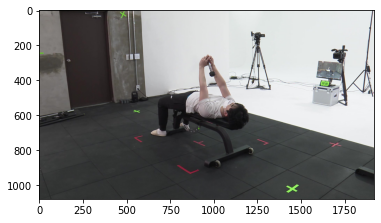

In [4]:
plt.imshow(im)

In [5]:
train = pd.read_csv("data/ori/train_df.csv")

In [6]:
train

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,642-2-4-31-Z148_E-0000023.jpg,637.251052,781.342260,1117.135818,370.667301,1097.123228,330.642200,1095.455539,355.657874,1083.364600,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.997090,612.486105,616.404617,803.439462
4191,642-2-4-31-Z148_E-0000025.jpg,637.251052,781.342260,1117.135818,370.667301,1097.123228,330.642200,1095.455539,355.657874,1083.364600,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.997090,612.486105,616.404617,803.439462
4192,642-2-4-31-Z148_E-0000027.jpg,637.251052,781.342260,1117.135818,370.667301,1097.123228,330.642200,1095.455539,355.657874,1083.364600,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.997090,612.486105,616.404617,803.439462
4193,642-2-4-31-Z148_E-0000029.jpg,637.251052,781.342260,1117.135818,370.667301,1097.123228,330.642200,1095.455539,355.657874,1083.364600,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.997090,612.486105,616.404617,803.439462


In [12]:
xpos = train.to_numpy()[:, 1::2]
ypos = train.to_numpy()[:, 2::2]

In [13]:
xpos.shape, ypos.shape

((4195, 24), (4195, 24))

In [15]:
xpos.max(), xpos.min()

(1440.2047919689292, 484.71572440839975)

In [16]:
ypos.max(), ypos.min()

(969.317126766628, 160.46791743853043)

In [17]:
im.shape

(1080, 1920, 3)

적절히 여유를 둬서  
x축은 400 ~ 1500  
y축은 100 ~ 1000  
까지만 사용하도록 하자